<div style="text-align: center;">
    <hr style="border: 2px solid #FFB300; width: 90%; margin: 22px auto;">
    <h1 style="color: #1A237E; font-size: 2.5em; font-family: 'Arial Black', sans-serif;">
        DERMA SCAN IA: PREDIAGNÓSTICO DE ENFERMEDADES DE LA PIEL CON INTELIGENCIA ARTIFICIAL
    </h1>
    <hr style="border: 2px solid #FFB300; width: 90%; margin: 20px auto;">
    
    Realizado por: Samantha Suquilanda, Felipe Peralta, Andres Torres y Kevin Chipantiza
     
</div>

### INDICE DE CLASES
1. [ ANÁLISIS EXPLORATORIO](#introduccion-al-procesamiento-de-senales-biomedicas)  
1.1. [Descripción de la Problemática y Data set](#adquisicion-y-digitalizacion-de-senales)  
1.2. [ Procesamiento del Dataset](#filtrado-y-eliminacion-de-ruido-en-senales-biomedicas)  
1.2.2. [Configuración base del entorno](#gráfica-de-señales-principales)  
1.2.3. [Dividir la Dataset en Train y Test](#analisis-en-el-dominio-del-tiempo-y-la-frecuencia)  
2. [Creación de DataLoader con muestreo balanceado](#normalizar-una-senal)  
3. [ Carga de modelo preentrenado (EfficientNet)](#introduccion-al-procesamiento-de-senales-biomedicas)  
4. [Definición de loss, optimizador y scheduler](#adquisicion-y-digitalizacion-de-senales)  
5. [ Entrenamiento principal del modelo](#filtrado-y-eliminacion-de-ruido-en-senales-biomedicas)  
6. [Visualización de curvas de pérdida y precisión](#gráfica-de-señales-principales)  
7. [Evaluación del modelo final](#analisis-en-el-dominio-del-tiempo-y-la-frecuencia)  
8. [Conclusiones](#normalizar-una-senal)
9. [Referencias](#normalizar-una-senal)  
<hr style


<span style="color:#00008B; font-size:22px;">**ANÁLISIS EXPLORATORIO**:</span> 


<span style="color:#00008B; font-size:18px;">**1.1 Descripción de la Problemática y Data set**:</span> 


En esta práctica se aborda un problema de clasificación multicategoría de imágenes médicas, enfocado en identificar diversas enfermedades dermatológicas mediante redes neuronales convolucionales (CNN). El objetivo principal es construir un modelo capaz de reconocer correctamente la enfermedad de la piel correspondiente a una imagen clínica, simulando el trabajo preliminar de un dermatólogo.


**Dataset utilizado:** `Skin Diseases Dataset`
Este dataset es una recopilación de imágenes provenientes de tres fuentes abiertas:

- Skin Diseases Dataset (Hossain, 2022)
- Dermnet Skin Diseases Database (DermNet, 2022)
- Dermatology Atlas (2022)
- El dataset incluye imágenes variadas en condiciones clínicas reales, con diferentes tonos de piel, tipos de iluminación, y encuadres.

**Las características del dataset son las siguientes:**
- Cantidad total de imágenes: 38,760 imágenes aproximadamente.
- Número de clases o etiquetas: 6 categorías dermatológicas.
    1. `Enfeksiyonel:` Enfermedades infecciosas de la piel.
    2. `Ekzama:` Eczema y afecciones inflamatorias.
    3. `Akne:` Acné.
    4. `Pigment:` Alteraciones pigmentarias.
    5. `Benign:` Tumores benignos de la piel.
    6. `Malign:` Tumores malignos de la piel.    
- Distribución de imágenes: Repartidas en carpetas train, val y test, cada una con sus 6 subcarpetas por clase.
El número exacto por clase y conjunto será determinado en el análisis exploratorio.
- Dimensiones de entrada: Las imágenes presentan tamaños y resoluciones variables. Serán redimensionadas a `224 × 224 píxeles`, formato RGB (3 canales), para estandarizar su entrada a la red neuronal.
- Formato de etiquetas: entero, codificado numéricamente del `0 al 5`.

**Desafío importante:** El dataset incluye imágenes capturadas en entornos clínicos reales, lo que implica:
- Variabilidad en la calidad y resolución.
- Cambios en el tono de piel.
- Diversas condiciones de iluminación.
- Encadres no siempre centrados.
  
Este desafío simula el diagnóstico preliminar en situaciones del mundo real, donde los modelos deben generalizar correctamente ante condiciones visuales diversas.

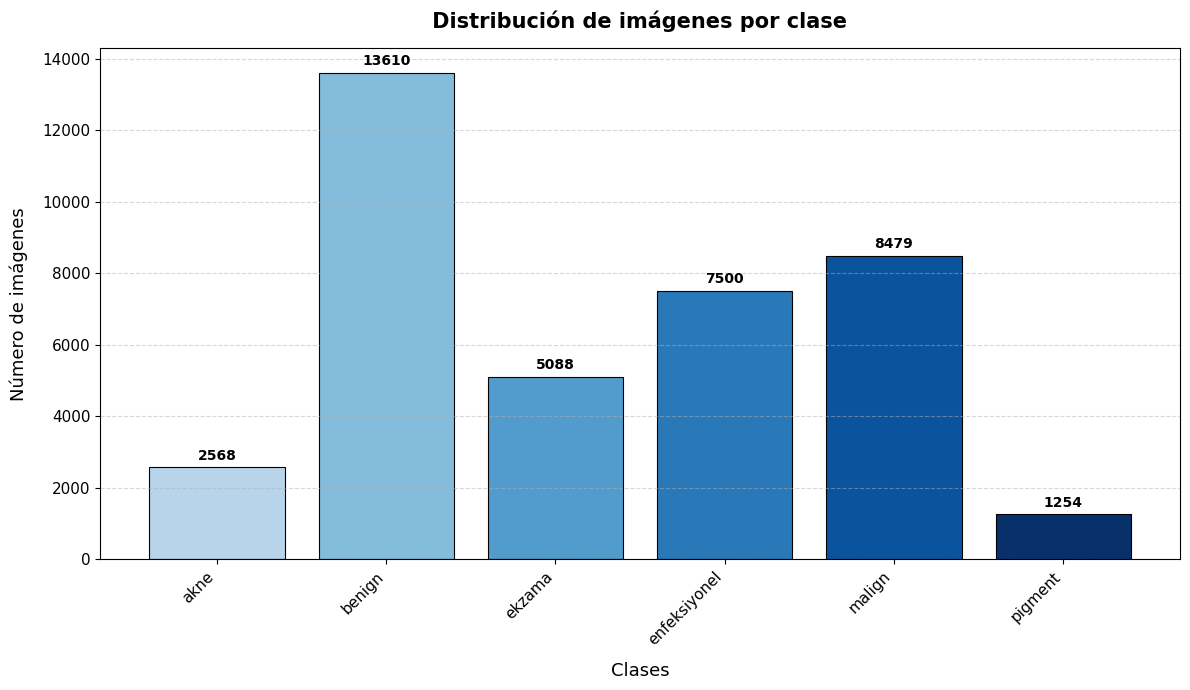

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

data_dir = r"C:\Users\Gorgi\Desktop\Octavo Ciclo\IA\Proyecto\redimension"

classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
classes.sort()

counts = []
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    counts.append(num_images)

colormap = plt.get_cmap('Blues')
colors = [colormap(0.3 + 0.7 * (i / max(len(classes)-1, 1))) for i in range(len(classes))]

plt.figure(figsize=(12, 7))
bars = plt.bar(classes, counts, color=colors, edgecolor='black', linewidth=0.8)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(counts)*0.01,
             str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Clases", fontsize=13, labelpad=10)
plt.ylabel("Número de imágenes", fontsize=13, labelpad=10)
plt.title(" Distribución de imágenes por clase ", fontsize=15, fontweight='bold', pad=15)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



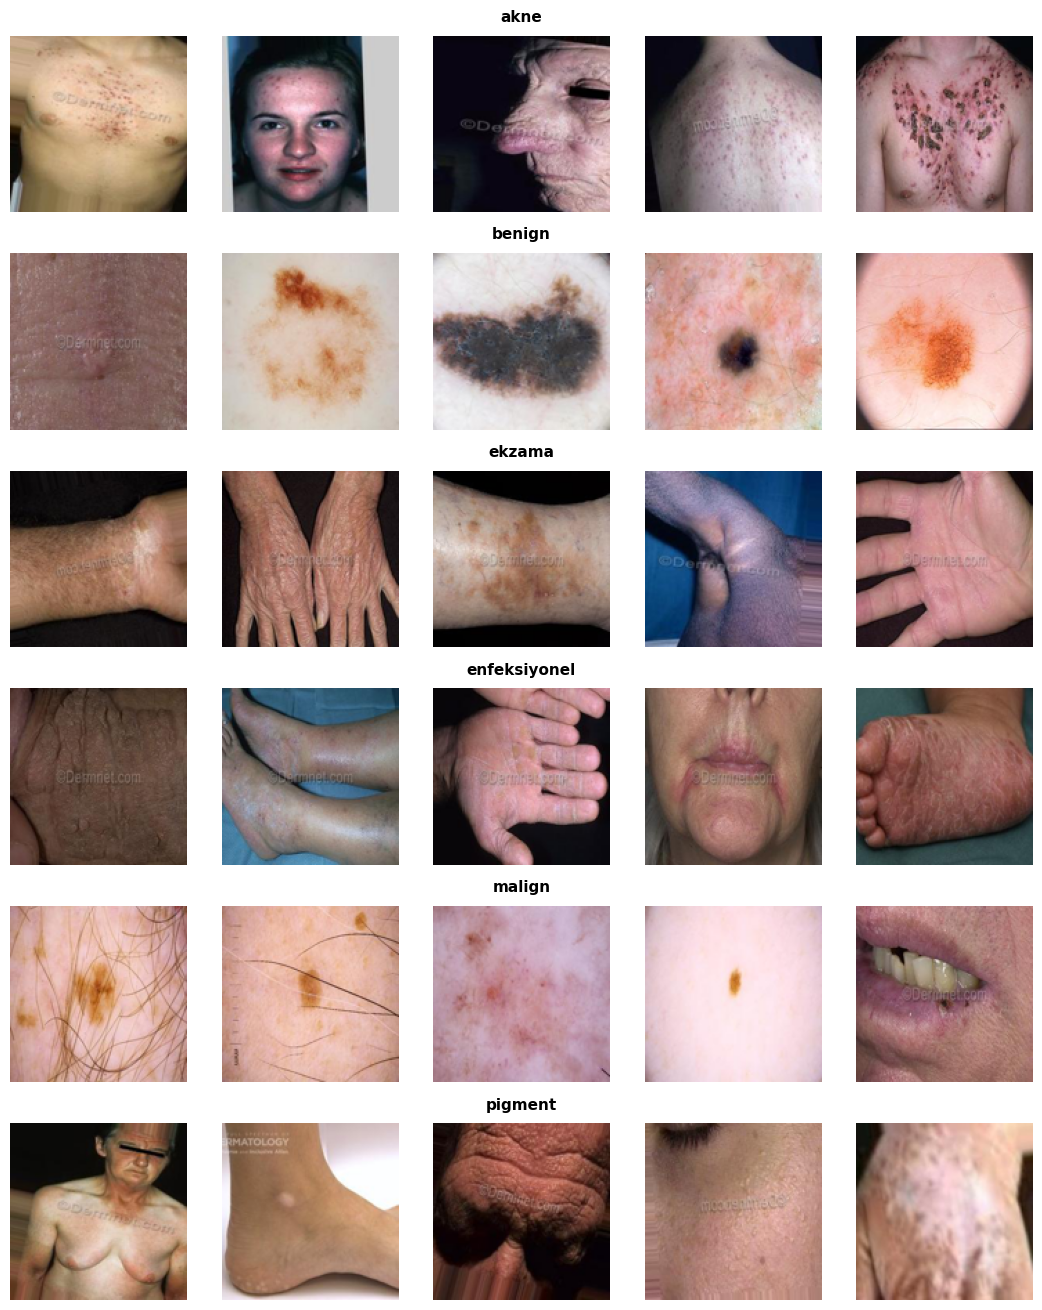

In [ ]:
# GRÁFICA DE 5 IMAGENES POR CADA CLASE DE MANERA ALEATORIA.
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

data_dir = r"C:\Users\Gorgi\Desktop\Octavo Ciclo\IA\Proyecto\redimension_balanceado_8000_train_test\train"

num_images_per_class = 5
image_size = (128, 128)

classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(num_images_per_class * 2.2, len(classes) * 2.2))
fig.subplots_adjust(hspace=0.5)

for row_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    selected_images = random.sample(images, min(num_images_per_class, len(images)))

    for col_idx, image_name in enumerate(selected_images):
        img_path = os.path.join(class_path, image_name)
        image = Image.open(img_path).convert("RGB").resize(image_size)

        ax = axes[row_idx, col_idx] if len(classes) > 1 else axes[col_idx]
        ax.imshow(image)
        ax.axis("off")

        if col_idx == num_images_per_class // 2:
            ax.set_title(class_name, fontsize=11, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()


<span style="color:#00008B; font-size:18px;">**1.2 Procesamiento del Dataset**:</span> 



 **1.2.1 Balanceo de clases con data augmentation:**
Este script genera un nuevo conjunto de datos balanceado en la carpeta `redimension_balanceado_8000`, asegurando que cada clase contenga exactamente 8000 imágenes.

**Funcionalidad**

- Lee las subcarpetas de clases desde la carpeta `redimension`.
- Si una clase tiene más de 8000 imágenes, selecciona una muestra aleatoria de 8000 (downsampling).
- Si tiene menos de 8000, copia las imágenes originales y genera nuevas mediante data augmentation hasta alcanzar el total requerido.

**Transformaciones aplicadas:**
Se utiliza `ImageDataGenerator` con las siguientes transformaciones:

- Rotación aleatoria (±15°)
- Zoom (±10%)
- Desplazamientos horizontales y verticales
- Inversión horizontal
- Reescalado de píxeles a [0, 1]

**Resultado:**
Cada clase en `redimension_balanceado_8000` contiene exactamente 8000 imágenes, balanceadas mediante una combinación de datos originales y aumentados, listas para su uso en modelos de clasificación.


In [ ]:
# DATA AUGMENTATION A 8000 IMAGENES 
origen = "redimension"  
destino = "redimension_balanceado_8000" 
limite = 8000

os.makedirs(destino, exist_ok=True)

augmentador = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

for clase in os.listdir(origen):
    ruta_origen = os.path.join(origen, clase)
    ruta_destino = os.path.join(destino, clase)
    os.makedirs(ruta_destino, exist_ok=True)

    imagenes = os.listdir(ruta_origen)
    total_actual = len(imagenes)
    
    # Si la clase tiene más de 500 imágenes, reducimos
    if total_actual > limite:
        print(f"Reduciendo {clase} a {limite} imágenes...")
        imagenes = random.sample(imagenes, limite)  # Tomamos una muestra aleatoria
        total_actual = limite
    
    # Copiar las imágenes (ya sea las originales o la muestra reducida)
    for imagen in imagenes:
        shutil.copy(os.path.join(ruta_origen, imagen), os.path.join(ruta_destino, imagen))

    faltan = limite - total_actual

    if faltan > 0:
        # Crear un generador solo para esta clase
        temp_gen = augmentador.flow_from_directory(
            origen,
            classes=[clase],
            target_size=(224, 224),
            batch_size=1,
            save_to_dir=ruta_destino,
            save_prefix='aug_',
            save_format='jpeg'
        )

        # Generar imágenes nuevas hasta llegar al límite
        print(f" Aumentando {clase}: generando {faltan} nuevas imágenes...")
        for i in range(faltan):
            next(temp_gen)

La gráfica muestra un dataset balanceado, con `6400` imágenes por clase. Se aplicó data augmentation a las clases minoritarias para `evitar sesgos` durante el entrenamiento y `mejorar` la generalización del modelo.

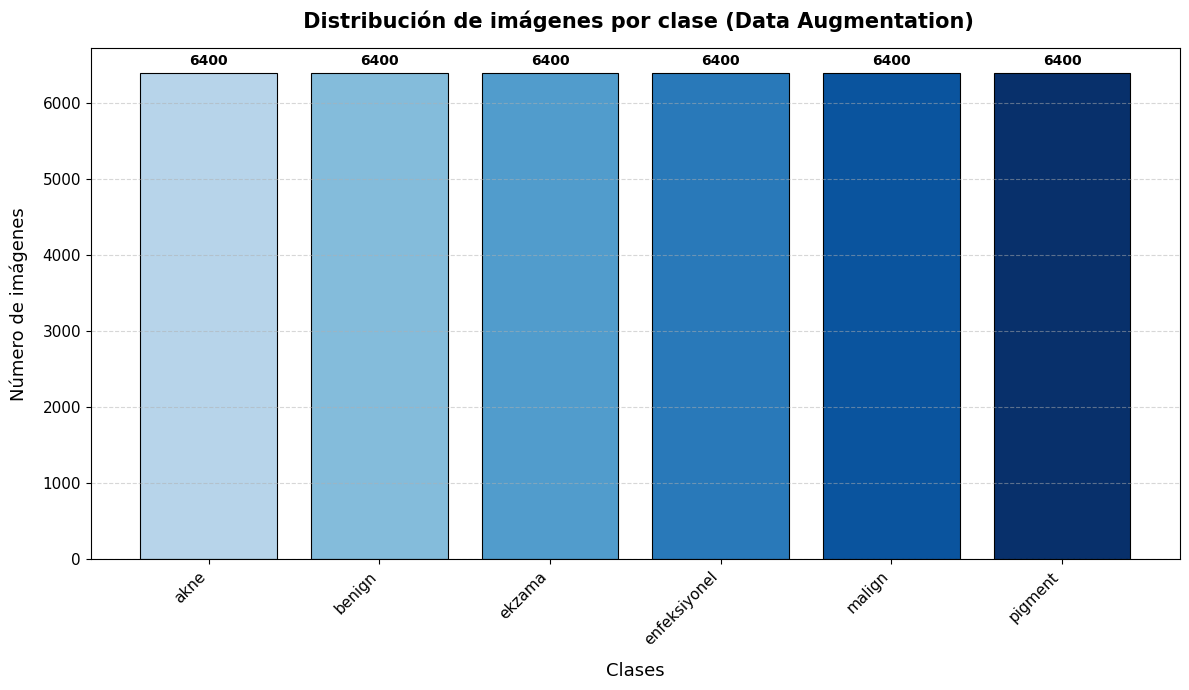

In [9]:
# HISTOGRAMA APLICADO EL DATA AUGMENTATION
import os
import matplotlib.pyplot as plt
import numpy as np

# Ruta a tu dataset
data_dir = r"C:\Users\Gorgi\Desktop\Octavo Ciclo\IA\Proyecto\redimension_balanceado_8000_train_test\train"

# Obtener nombres de clases (subcarpetas)
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
classes.sort()

# Contar imágenes por clase
counts = []
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    counts.append(num_images)

# Tonalidades de azul: más claro a más oscuro
colormap = plt.get_cmap('Blues')
colors = [colormap(0.3 + 0.7 * (i / max(len(classes)-1, 1))) for i in range(len(classes))]

# Crear gráfico
plt.figure(figsize=(12, 7))
bars = plt.bar(classes, counts, color=colors, edgecolor='black', linewidth=0.8)

# Etiquetas sobre las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(counts)*0.01,
             str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Estética de ejes y título
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Clases", fontsize=13, labelpad=10)
plt.ylabel("Número de imágenes", fontsize=13, labelpad=10)
plt.title(" Distribución de imágenes por clase (Data Augmentation)", fontsize=15, fontweight='bold', pad=15)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



**1.2.2 Configuración base del entorno**En esta celda se definen los parámetros fundamentales para el entrenamiento del modelo:

- `SEED = 42`: Se fija una semilla para asegurar reproducibilidad en los experimentos, es decir, que los resultados sean consistentes entre ejecuciones.
- `BATCH_SIZE = 32`: Tamaño del lote o cantidad de imágenes que se procesan simultáneamente durante cada paso de entrenamiento.
- `IMG_SIZE = 224`: Tamaño al que se redimensionan todas las imágenes, compatible con modelos como EfficientNet o ResNet.

In [12]:
import torch

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Dispositivo usado:", device)

# Optimizar rendimiento para convoluciones
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True


 Dispositivo usado: cuda


In [13]:
#  Librerías principales
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim

print("Librerías importadas")


Librerías importadas


In [14]:
# Configuraciones base
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Usando:", device)

SEED = 42
torch.manual_seed(SEED)

BATCH_SIZE = 64
IMG_SIZE = 224

print(" Celda completada: Configuración general")


 Usando: cuda
 Celda completada: Configuración general


**1.2.3 Dividir la Dataset en Train y Test:**
Antes de entrenar el modelo, se redimensionaron todas las imágenes del Skin Diseases Dataset a un tamaño uniforme para garantizar consistencia en la entrada.

Luego, el dataset fue dividido en dos subconjuntos principales:

- 80% para entrenamiento, utilizado para aprender los patrones de las clases.

- 20% para prueba, con datos no vistos.

Esta división se realizó de forma balanceada por clase, asegurando una distribución equitativa. Posteriormente, el 20% de prueba se dividió en partes iguales para formar los conjuntos de validación (10%) y test final (10%), lo que permitió ajustar hiperparámetros y evaluar el rendimiento del modelo de forma objetiva.


In [15]:
# Ruta local a tu dataset
data_dir = r"C:\Users\Gorgi\Desktop\Octavo Ciclo\IA\Proyecto\redimension_balanceado_8000_train_test"

# Transformaciones
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#  Dataset por carpetas
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transforms)

# Dividir test en val + test reales (50/50)
val_size = int(0.5 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, final_test_dataset = torch.utils.data.random_split(test_dataset, [val_size, test_size])

NUM_CLASSES = len(train_dataset.classes)
print("Clases detectadas:", train_dataset.classes)
print("Celda completada: Datos cargados y transformados")


Clases detectadas: ['akne', 'benign', 'ekzama', 'enfeksiyonel', 'malign', 'pigment']
Celda completada: Datos cargados y transformados


**2.Creación de DataLoader con muestreo balanceado:**
Para evitar que el modelo se sesgue hacia clases con más ejemplos, se utiliza un `WeightedRandomSampler`. Este muestreador ajusta la probabilidad de que cada imagen sea seleccionada durante el entrenamiento, de modo que todas las clases tengan la misma importancia. Luego, se definen los `DataLoader` para entrenamiento, validación y prueba.

In [16]:
#  Aplicar muestreo balanceado
targets = [label for _, label in train_dataset]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

#  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(" Celda completada: Sampler y DataLoaders listos")


 Celda completada: Sampler y DataLoaders listos


**3.Carga de modelo preentrenado (EfficientNet):**
Se carga una versión preentrenada de `EfficientNet-B0`, una arquitectura eficiente y moderna para clasificación de imágenes. Se reemplaza la capa final (_fc) para ajustarse al número de clases del dataset dermatológico.

In [17]:
#  Cargar modelo preentrenado
model = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

print(" Celda completada: Modelo EfficientNet listo")


Loaded pretrained weights for efficientnet-b0
 Celda completada: Modelo EfficientNet listo


**4.Definición de loss, optimizador y scheduler:**
Se configura la función de pérdida (CrossEntropyLoss) para clasificación multiclase, el optimizador Adam, y un scheduler que reduce la tasa de aprendizaje si la pérdida de validación no mejora.



In [18]:
# Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

print("Celda completada: Optimizador, loss y scheduler definidos")


Celda completada: Optimizador, loss y scheduler definidos


**5.Entrenamiento principal del modelo:**
Aquí se entrena el modelo por `20 épocas` y `BATCH_SIZE = 64`. Se realiza un ciclo de entrenamiento sobre los datos y luego una evaluación sobre el conjunto de validación. Se calcula y guarda el mejor modelo si la pérdida de validación mejora.

In [ ]:
import time

EPOCHS = 20
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model.to(device)  # Asegurar que el modelo esté en la GPU

for epoch in range(EPOCHS):
    start_time = time.time()

    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validación
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(avg_val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"📚 Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
          f"⏱ Tiempo: {epoch_time:.2f} s")

    # Guardar el mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, "best_model.pth")
        print(" Modelo guardado (nuevo mejor)")

print(" Entrenamiento finalizado")


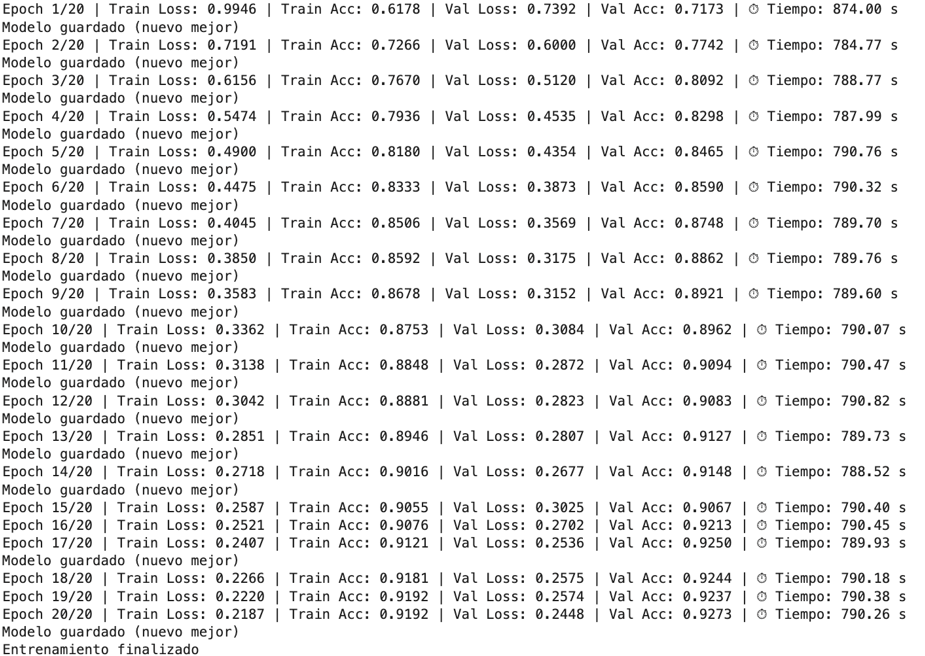

In [33]:
from IPython.display import Image, display

# Mostrar la imagen con un ancho ajustado (en píxeles)
display(Image(filename=r"C:\Users\Gorgi\Desktop\Métricas.png", width=600))  # Ajusta a lo que necesites


**6.Visualización de curvas de pérdida y precisión:**
Se grafican las curvas de pérdida y exactitud (accuracy) durante las épocas, tanto para entrenamiento como validación. Estas gráficas permiten identificar si hay sobreajuste o subajuste en el modelo.

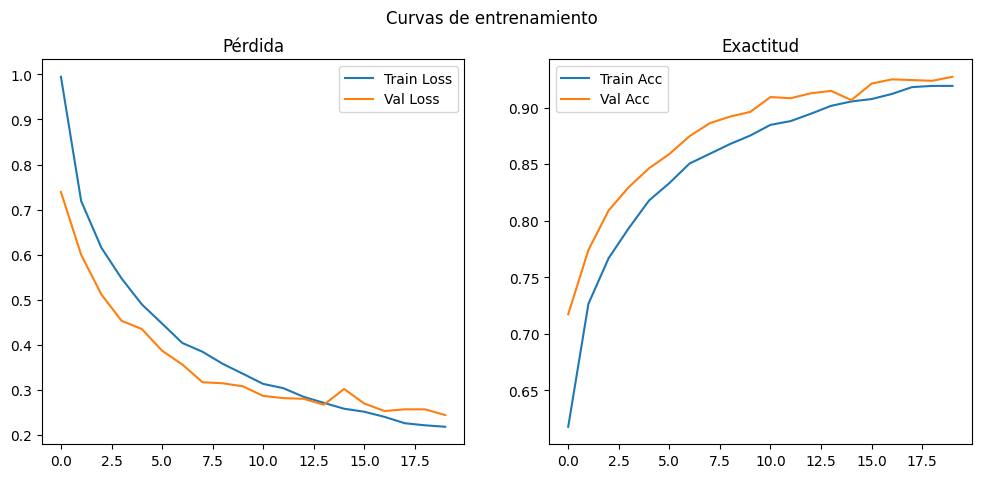

✅ Celda completada: Gráficas mostradas


In [9]:
#  Curvas de pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Exactitud")
plt.legend()

plt.suptitle("Curvas de entrenamiento")
plt.show()

print(" Celda completada: Gráficas mostradas")


 Modelo completo cargado correctamente.

 Clasificación por clase:
              precision    recall  f1-score   support

        akne       0.97      0.98      0.97       822
      benign       0.90      0.87      0.88       809
      ekzama       0.92      0.94      0.93       782
enfeksiyonel       0.91      0.88      0.89       786
      malign       0.86      0.89      0.88       796
     pigment       0.97      0.97      0.97       805

    accuracy                           0.92      4800
   macro avg       0.92      0.92      0.92      4800
weighted avg       0.92      0.92      0.92      4800



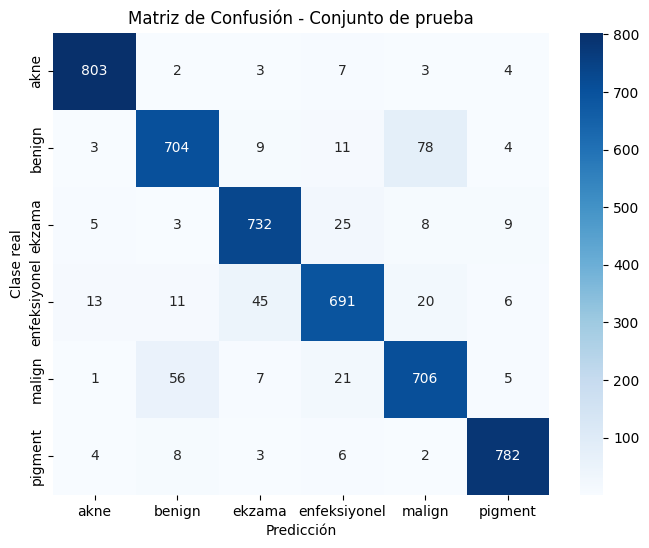

 Evaluación final realizada.


In [23]:
#  Evaluación del modelo completo 
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Cargar modelo completo (método 2)
model = torch.load("best_model.pth", weights_only=False)
model.to(device)
model.eval()
print(" Modelo completo cargado correctamente.")

# Predicción sobre el conjunto de prueba
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

#  Reporte de clasificación
class_names = train_dataset.classes
print("\n Clasificación por clase:")
print(classification_report(all_labels, all_preds, target_names=class_names))

#  Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión - Conjunto de prueba")
plt.show()

print(" Evaluación final realizada.")


In [24]:
#Predicción de imagen individual
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Transforms iguales al conjunto de prueba
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Función para predecir una imagen desde ruta
def predecir_imagen_desde_ruta(ruta_img):
    try:
        imagen = Image.open(ruta_img).convert('RGB')
    except Exception as e:
        print(f" Error al cargar la imagen: {e}")
        return

    input_tensor = transform(imagen).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probas = torch.nn.functional.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probas).item()
        pred_clase = class_names[pred_idx]
        confianza = probas[pred_idx].item()

    print(f" Clase predicha: {pred_clase}")
    print(f" Confianza: {confianza*100:.2f}%")

    plt.imshow(imagen)
    plt.axis('off')
    plt.title(f"{pred_clase} ({confianza*100:.2f}%)")
    plt.show()


 Clase predicha: akne
 Confianza: 99.98%


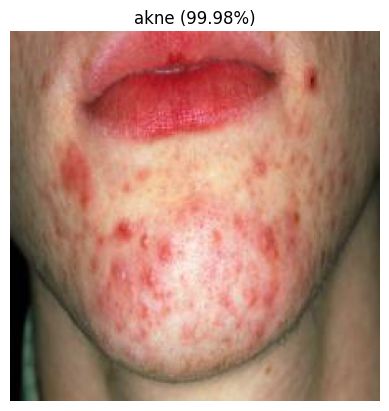

In [26]:
predecir_imagen_desde_ruta(r"C:\Users\Gorgi\Desktop\Octavo Ciclo\IA\Proyecto\redimension_balanceado_8000_train_test\test\akne\59.jpg")


<span style="color:#00008B; font-size:22px;">**Conclusiones**:</span> 

Este proyecto implementó un sistema de clasificación automática de imágenes dermatológicas usando una red EfficientNet-B0 preentrenada, aplicada sobre un subconjunto del dataset HAM10000 cuidadosamente seleccionado.

1.Uno de los principales desafíos fue el desbalance de clases, que podría haber causado un sesgo significativo hacia las clases más frecuentes. Para resolverlo, se aplicaron múltiples estrategias complementarias:

- Se generó un nuevo dataset balanceado con 8000 imágenes por clase, mediante submuestreo de clases mayoritarias y aumento de datos (data augmentation) en las minoritarias.
- Se aplicaron transformaciones aleatorias (rotaciones, recortes, volteos horizontales, etc.) durante el entrenamiento para mejorar la robustez del modelo y simular variabilidad en los datos.
- Se utilizaron pesos por clase en la función de pérdida para penalizar más los errores en clases minoritarias, lo que ayudó a reducir el sesgo residual tras el rebalanceo.

2.El entrenamiento se realizó con un split inicial de 80% para entrenamiento y 20% para validación, y luego el conjunto de validación se dividió 50/50 para pruebas finales, asegurando una evaluación objetiva y sin sobreajuste.

3.El modelo final alcanzó una precisión (accuracy) del 92%, con F1-scores equilibrados entre las distintas clases. Las métricas obtenidas y la matriz de confusión validan la eficacia del sistema, aunque se observan algunas confusiones razonables entre clases visualmente similares.

Además, se incorporó una herramienta de predicción individual, que permite cargar cualquier imagen externa y obtener su clase estimada con nivel de confianza, facilitando su uso en entornos reales.

En conjunto, el modelo mostró ser preciso, balanceado y confiable, gracias al enfoque integral que combinó arquitectura moderna, procesamiento de datos adecuado, ajustes ponderados y validación sólida.



<span style="color:#00008B; font-size:22px;">**Referencias**:</span> 
- Tschandl, P., Rosendahl, C., & Kittler, H. (2018). HAM10000 Dataset: A large collection of multi-source dermatoscopic images of common pigmented skin lesions. Harvard Dataverse.
https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
-  Howard, A. G., et al. (2017). *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks*. arXiv preprint arXiv:1905.11946.
-  Shorten, C., & Khoshgoftaar, T. M. (2019). *A survey on image data augmentation for deep learning*. Journal of Big Data, 6(1), 1–48.